# MICQP-based planning for a Multirotor 

Authors: Alan Papalia, Andrew Torgesen, Andrea Tagliabue 

Questions for TAs: 
- what is the difference in including in adding in the cost function the term |sn-sg| or adding instead the constraint that s(N) = s(G)??


## Introduction to Trajectory Optimization
The objective of trajectory optimization is to generate a time-parametrized path (a trajectory) which minimizes a given performance metric, while satisfying a set of constraints. This problem is closely  related to solving an optimal control, open-loop problem. 

In robotic applications, the planned trajectory is usually fed  as input to the motion control architecture of the robot, and has to satisfy strict requirements in terms of dynamic feasibility, smoothness, ability to be re-computed efficienty... 

Examples of performance metric for trajectory generation commonly found in robotics are:
- the energy required to follow the trajectory
- the control effort (often related to energy) required
- the average or maximum acceleration/jerk/snap 
- the time to execute the trakjectory.

Examples of constraints for trajectory generation typically found in robotics are:
- constraints from the environment, such as obstacles, static or dynamic, that must be avoided
- constraints on the performance of the system, such as the maximum control effort, or saturations on the actuators of the robot
- the final time and final state of the robot (e.g. when trying to intercept a moving object)
- kinematic and dynamic constraints (e.g. a car cannot move sideways or a quadcopter cannot accelerate horizonatally without pitching or rolling).

Trajectory optimization is usually considered as a local planning problem, since we are only interested in generating a trajectory which terminates a few meters away from the current position of the robot (but the termination point is constantly updated as the robot moves). In addition, trajectory optimizatio assumes that a desired initial state and final goal state are given (for example by a global planner/mission planner).

#### Mathematical formulation
The Trajectory optimizatio problem can be mathematically formulated as follows:
$$\min_{p} J(p)$$ $$ \text{s.t.} \\ p \in P$$

where $J(\cdot)$ is the objective function, $p$ represents all the possible input and state trajectories, and $P$ is the set of state trajectory satisfying given constraints. 

#### Techniques used to solve the trejectory optimization problem
The typical techniques used to solve a trajectory optimization problem can be grouped in two cathegories:
- Direct method: iteratively construct a numerical approximation to the solution to the problem. 
- Indirect method: analytically constructs the direct and sufficent conditions for optimality, which are then solved numerically.

#### Planning horizon
The trajectory can be usually planned w.r.t to a __fixed arrival time__ or on a __receding-horizon__ fashion. 

In the first case, all the trajectories $p$ in $P$ have to satisfy the additional constraint that the final state of the robot (position, velocity etc..) must be reached at the given time $T$.  In the second case, the trajectory is iteratively replanned for a given, small time horizon. At every time-step, the planner updates the current trajectory by re-planning a new trajectory with final time increased of one step from the previous final time. 

While the first approach has the advantage of minimizing the cost function along the entire trajectory, the second approach - despite offering a sub-optimal result - is less computationally expensive.  


Source: https://en.wikipedia.org/wiki/Trajectory_optimization

## Review on Convex Optimization, QP, QCQP,  LP, MILP, MIQCP
##### Convex Optimization
A convex optimization problem is an optimization problem in which the objective function is a convex function and the feasible set is a convex set. It can be formulated in the form:
$$\displaystyle \min_{x} f(x)$$
$$\text{subject to} \\ g_i(x) \leq 0, \ i=1, ..., m$$
$$\\ h_i(x) \leq 0, \ i=1, ..., p$$
where $f, g_1, ..., g_m$ are convex and $h_1, ..., h_p$ are affine constraints (note: affine constraints are indeed convex, but they are listed separately in this formulation for conveniency). 

Under these assumption, the problem has the following properties:
- every local minimum is a global minimum
- the optimal set is convex
- if the objective function  is strictly convex, then the problem has at most one optimal point.

##### Linear Programming
In linear programming, an optimization problem is characterized by:
- a linear cost function
- a linear set of inequality constraints
- non negative variables

It can thus be formulated in mathematical form as:
$$\displaystyle \max_{x} c^Tx$$
$$ \text{subject to} \\ Ax\leq b \\x \geq 0 $$ 
 
Geometrically, the inequlity constraints, which define the feasible region, describe a convex polyhedron. The linear objective function is a convex function, which implies that every local minimum is a global minimum. A LP/MILP is then a convex optimization problem.
A solution is guaranteed to exist under the assumptions that the problem is feasible (the feasible space described by the constraints is non-zero) and that the problem is not unbounded.

##### Mixed Integer Linear Programming
A linear problem is said to be integral if it has at least one optimal solution which is integral. This means that the domain of some of the optimixation variables $x$ is defined on $Z$. 

##### (Quadratically Constrained) Quadratic Programming
A quadratic program is an optimization problem where the cost function is quadratic. The cost function has the form:
$$f(x)=\frac{1}{2}x^TQx + c^Tx$$

If the constraints are expressed in quadratic form, then the problem is said to be Quadratically Constrained. In a QCQP, the constraints can be expressed as:
        $$g_i(x) = \frac{1}{2}x^TP_ix + q_i^Tx + r_i \leq 0 \\ \text{for} \ i = 1, ..., m$$
Linear or affine constraints can also be included (e.g $Ax = b$)

#### Mixed Integer Quadratically Constrained Programming
If a proble has any constraints containing a quadratic term, regardless of the objective function, the problem is termed a Mixed Integer Quadratically Constrained Program (MIQCP). Since the problem is also a Mixed-Integer, then the domain of some of the optimization variables is defined oin $Z$.

Sources: https://en.wikipedia.org/wiki/Linear_programming, https://en.wikipedia.org/wiki/Convex_optimization, https://en.wikipedia.org/wiki/Quadratically_constrained_quadratic_program, https://support.sas.com/rnd/app/or/procedures/milp.html

## Solving Convex Optimization Problems

Now that we've spent the time to understand convex spaces, it is time to discuss how to use this *magical* property called convexity to reach optimal solutions. As we've discussed, convexity is an important property that generally allows us to guarantee that we can find an optimal solution. 

Beyond living in a convex space, the other requirement of a convex optimization problem is that the actual **function** being optimized is also **convex**. A convex function can be formally defined as follows:

\begin{equation*}
\text{for any x,y for which the function, f(*), exists and 0 $\leq$ a $\leq$ 1} \\
f(ax + (1-a)y) \leq af(x)+(1-a)f(y) \\
\end{equation*}

This can be easily visualized in the below diagram:

<img src="convexfunction.png" style="width:50%;"/>


By <a href="//commons.wikimedia.org/w/index.php?title=User:Eli_Osherovich&amp;action=edit&amp;redlink=1" class="new" title="User:Eli Osherovich (page does not exist)">Eli Osherovich</a> - <span class="int-own-work" lang="en">Own work</span>, <a href="https://creativecommons.org/licenses/by-sa/3.0" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=10764763">Link</a>

These two requirements, both a convex set and function, enforce the rule that **any local minima is also a global minima**. That's correct, please read that again. **Local minima = Global Minima**

Without further information, here is a primer on some common convex optimization approaches

### Gradient Methods

This technique does what any intelligent person would do when trying to find a minima: follow a path leading down. A gradient based method **requires???** the following parts:

1) A way to obtain a gradient of the function
2) A way to determine a "step size" in the direction of this gradient
3) Stopping criterion to determine if the solution is "close enough" to a minima

Gradient descent - calculates gradient of function  
Steepest descent - 1st order Taylor approximation of local gradient  
Newton's Method  - Minimizer of 2nd order Taylor approximation  (Linear equality constrained problem w/ twice diff. objective function into linear equality quadratic problem)

1) Randomly sample a point in space, x  
2) Calculate or approximate the local gradient of the function  
3) Move the point, x, a small amount in the steepest negative direction  
4) Repeat steps 2,3 until the point x has been determined to be in a minima  

**Note**: more sophisticated variants often vary the step size from step 3 based upon factors such as the steepness of the gradient. Also, there is no one correct answer to guessing whether a x has reached a minima. 

### Interior Point Methods (IPM)

Interior point methods take an optimization problem with linear equality and inequality constraints and reshape into linear equality constrained problems

#### Barrier Method 

The Barrier Method is a form of IPM in which general inequality constraints are made implicit by moving them into the objective function. 

The value of the objective function is made to be infinite at any points which were previously outside of the feasible set as marked by the inequality constraints. This is done by use of an indicator function, $I(x)$. Formally speaking, this can be said as:

$f(x)$ is the objective function  
$f_0(x)$ is the original objective function  
$I(u)$ is the indicator function  
$f_i(x)$ represents the implicit inequalities  
  
\begin{equation*}
f(x) = f_0(x) + \sum_{i=1}^mI(f_i(x))\\
\text{where: } I(u)=  \left\{
\begin{array}{ll}
      0 & u \leq 0 \\
      \infty & u \gt 0 \\
\end{array} 
\right.
\end{equation*}

While this formulation is elegant, it is **not differentiable** and does not lend itself to techniques such as Newton's Method. This inspired the use of a **logarithmic barrier** of the form:

\begin{equation*}
\hat{I}(u ) = -(1/t)log(-u)\\
t \gt 0
\end{equation*}

This alternative indicator function maintains the convexity and differentiability of the problem while allowing for good approximation of the original barrier. 

**Note**: increasing the value of $t$ increases the accuracy of the approximation


#### Primal-Dual Method


### Simplex Method

**Note**: Dantzig's Simplex Method is only valid for **linear programs**, and does not generalize to the greater class of convex optimization problems. Regardless, it is briefly covered here for completeness.

The simplex method leverages the inherent monotonicity of a linear program and bears the relatively strict requirements of an LP such as a linear objective function and a feasible set which can be represented as a convex polytope. 

Because the objective function is monotonic and the feasible set is defined by linear inequalities, it can be shown that if an optimal point exists it will be at one of the vertices of the convex polytope. As a result, the algorithm simply begins at one such vertex and follows the connected edge of the polytope which is most rapidly approaching an optimal solution of the objective function (the edge with the most negative gradient in the case of minimization). This behavior continues until the algorithm reaches the optimal point within the polytope.

**Note**: in the case of a feasible set that is an open convex polytope it is possible for the optimal solution to not exist, as the simplex method may discover an unbounded edge. In this case, the solution is not feasible and further constraints must be imposed upon the feasible set to allow for a solution.

The image below visualizes Dantzig's Simplex Method over a 3-dimensional convex polytope

<img src="simplex.png" style="width:20%;"/>


By <a href="//commons.wikimedia.org/wiki/User:Sdo" title="User:Sdo">User:Sdo</a> - Created using gimp based on <a href="//commons.wikimedia.org/wiki/File:Elongated_pentagonal_orthocupolarotunda.png" title="File:Elongated pentagonal orthocupolarotunda.png">Image:Elongated_pentagonal_orthocupolarotunda.png</a>., <a href="http://creativecommons.org/licenses/by-sa/3.0/" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=1295511">Link</a>




## MIQCP-based, receding-horizon planner for a Multirotor
In this section we apply the MIQCP optimization technique to solve the trajectory generation problem for a quadcopter in a receding-horizon fashion.


### Dynamic Model of the Multirotor

We will consider for our dynamic system a vertical takeoff and landing (VTOL) unmanned air vehicle (UAV) that is confined to the plane. Below is a diagram illustrating the system and its state variables:

![](VTOL.svg)

The equations of motion that govern the system can be expressed as

$$(m_c+m_r+m_l)\ddot{z}=-(F_l+F_r)\sin \theta$$

$$(m_c+m_r+m_l)\ddot{h}+g(m_c+m_r+m_l)=(F_l+F_r)\cos \theta$$

$$(m_l d^2+m_r d^2+J_c)\ddot{\theta}+(m_r-m_l)gd\cos \theta=(F_r-F_l)d$$

where $z$ is the horizontal coordinate of the VTOL, $\theta$ is the clockwise deviation of the right rotor from the horizontal, $h$ is the VTOL altitude, $F_l$ and $F_r$ are the left and right rotor thrusts, and with the parameter definitions:

| Variable | Explanation            | Value        |
|----------|------------------------|--------------|
| $m_c$      | Mass of VTOL body      | 1 $kg$         |
| $m_l$      | Mass of left rotor     | 0.25 $kg$      |
| $m_r$      | Mass of right rotor    | 0.25 $kg$      |
| $J_c$      | VTOL Moment of inertia | 0.0042 $kg~m^2$ |
| $d$        | Rotor arm length       | 0.3 $m$        |
| $\mu$      | Air drag term          | 0.1 $kg/s$     |
| $g$        | Gravity                | 9.81 $m/s^2$   |

For the purpose of trajectory generation, we provide a simplified model of the system, founded on the following assumptions:

  - The longitudinal and lateral dynamics of the VTOL can be considered as decoupled (separate) systems
  - The dynamics can be considered as linear within a finite state space region surrounding the "equilibrium" flight regime, which is characterized by steady, level flight.
  
With the above assumptions, here is the simplified state-space model of the VTOL:

$$\dot{x}_{lon}=\begin{bmatrix}0 & 1 \\ 0 & 0\end{bmatrix}x_{lon}+\begin{bmatrix}0\\\frac{1}{m_l+m_r+m_c}\end{bmatrix}u_{lon}$$

$$y_{lon}=\begin{bmatrix}1 & 0\end{bmatrix}x_{lon}$$

$$\dot{x}_{lat}=\begin{bmatrix}0 & 0 & 1 & 0\\0 & 0 & 0 & 1\\0 & -g & \frac{-\mu}{m_c+m_l+m_r} & 0\\0 & 0 & 0 & 0\end{bmatrix}x_{lat}+\begin{bmatrix}0\\0\\0\\\frac{1}{m_ld^2+m_rd^2+J_c}\end{bmatrix}u_{lat}$$

$$y_{lat}=\begin{bmatrix}1&0&0&0\\0&1&0&0\end{bmatrix}x_{lat}$$

where $x_{lon}=\begin{bmatrix}h&\dot{h}\end{bmatrix}^T$,  $x_{lat}=\begin{bmatrix}z&\theta&\dot{z}&\dot{\theta}\end{bmatrix}^T$, $u_{lon}\triangleq F =f_r+f_l$, and $u_{lat}\triangleq \tau=d(f_r-f_l)$.

In [3]:
import vtolParam as P
from vtolAnimation import vtolAnimation
from vtolDynamics import vtolDynamics
from IPython.display import HTML
from math import sin, pi
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib notebook
plt.rcParams["animation.html"] = "jshtml"

Traceback (most recent call last):
  File "/home/andrea/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/andrea/.local/lib/python3.6/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


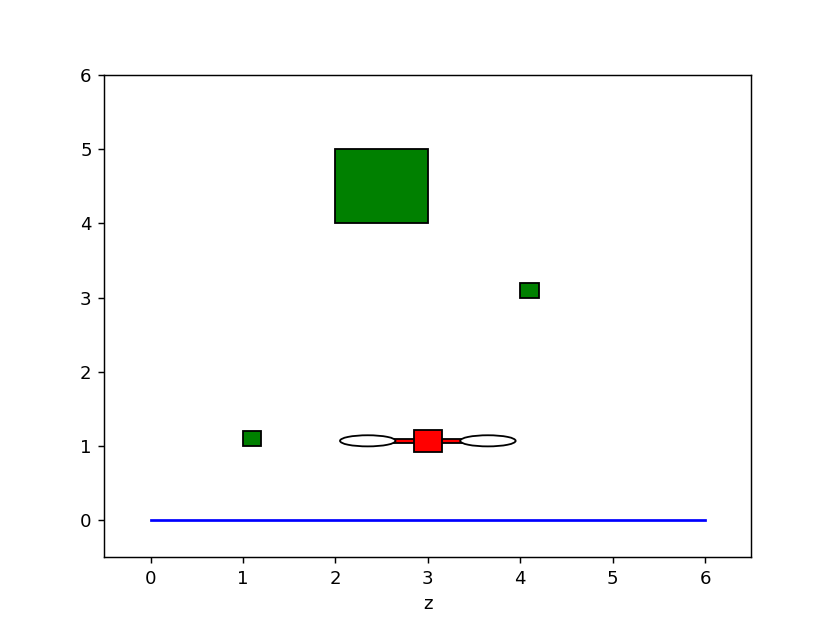

In [4]:
%matplotlib notebook
plt.rcParams["animation.html"] = "jshtml"

n = int((P.tf-P.t0)/P.Ts)
int((P.tf-P.t0)/P.Ts)
def getTime(i):
    return P.t0 + i * P.Ts

# Get inputs to system (will come from optimization)
inputs = list()
for i in range(0, n):
    t = getTime(i)
    F = P.Fe
    T = 0.0
    if t < 5:
        F += 0.1
    else:
        T += 0.1
    inputs.append([F, T])

# Obstacle Definitions
# list of ((x_min, y_min),(x_max, y_max)) tuple pairs
obstacles = [((1,1),(1.2,1.2)),((4,3),(4.2,3.2)),((2,4),(3,5))]
    
# Simulation + Animation
vtol = None
animation = vtolAnimation()
animation.addObstacles(obstacles)
def animate(i):
    global vtol
    if i == 0:
        vtol = vtolDynamics()
    vtol.propagateDynamics(inputs[i])
    animation.drawVtol(vtol.outputs())
ani = matplotlib.animation.FuncAnimation(animation.fig, animate, n, interval=1000*P.Ts)

### Non-linear, non-convext continuous time trajectory optimization problem formulation 
The trajectory optimization problem for our VToL which has to navigatve trough obstacles can be formulated in the way described in the following paragraphs. We will assume that the trajectory is planner in a receding horizon fashion.  Due to the presence of constraints (such as on the velocity) which involve both the lateral and longitudinal dynamics, the optimization problem cannot be decoupled.

#### Continuous time objective function
We use a minimum control effort criteria (which is related to minimizing the energy used by the VTOL, since the square of the thrust force produced by the propellers is roughly proportional to the instant power consumption)

$$\displaystyle \min_{x(t) \ u(t)} J(x(t), u(t), t)$$

where: $$J(x(t), u(t), t) = \int_{t_0}^{t_0 + T} u(t)^TRu(t) \ dt$$ 

with 

$$x(t) = [x^T_\text{lat}(t), x^T_\text{lon}(t)]^T \in R^6$$ 
$$u(t) = [u^T_\text{lat}(t), u^T_\text{lon}(t)]^T \in R^2$$

and the scalar $t_0 \in R$ is and arbitrary initial time and  $T \in R$ is the fixed total time to execute the trajectory and $R \in R^{2x2} is a positive definitie weight matrix.

#### Constraints
Notation declaration: for conveninency, we drop the time-dependency notation as it can be deduced without ambiguity from the context. 
The set of constraints considered are the following:
- System dynamics (not-linearized)
$$ \dot{x}(t) = f(x(t), u(t), t) $$
- Avoiding static obstacles:
**TODO: Alan: Explain and rename variable because x is our state!**
\begin{equation*}
x_i \leq x_{min} \\
\text{or } x_i \geq x_{min} \\
\text{or } y_i \leq y_{min} \\
\text{or } y_i \geq y_{min} \\
\end{equation*}
- Maximum velocity
$$ ||[\dot{h}, \dot{z}]^T||_{l_2} \leq \bar{v}$$
where $\bar{v}$ is a maximum given velocity.
- Fixed arrival time, initial and final position
$$x(0) = \bar{x}_0$$
$$u(0) = \bar{u}_0$$
$$x(T) = \bar{x}_g$$
$$T = \bar{T}$$
- Saturation on the actuators 
$$u(t) \geq \bar{u}$$

### MIQCP, receding-horizon formulation
We now linearize the previous formulation and provide a mixed-integer quadratic convex mathematical program that can be easily computed with existing solvers.

Though the concept of convexity extends to n-dimensions, we will focus on showing convexity of a 2D space for navigation. It can be simply seen that the introduction of an obstacle into a convex area including the vehicle and its destination, will cause the area to become non-convex. 

We work around this non-convexity by formulating the problem as a mixed integer program, with binary variables that vary depending on the region the vehicle is in at time *k*. These variables allow for all constraints to be flexibly satisfied **without having to address the combinatoric nature of the "or" formulation??????**.

#### Discrete time, state and input
Given a planning horizon $T_\text{hor}$ and the sampling time $\Delta t$, we obtain the number of discrite steps $N$ in the planning horizon as: 
with, given the planning horizon $T_\text{hor}$:
$$N = \frac{T_\text{hor}}{\Delta t}$$
We define the discretized state and input vectors at the discrete time-step $k$, given the sampling time $\Delta t$: 
$$x_k = [x_\text{lat}(t_0 + k\Delta t), \ x_\text{lon}(t_0 + k \Delta t)]$$
$$u_k = [u_\text{lat}(t_0 + k\Delta t), \ u_\text{lon}(t_0 + k \Delta t)]$$

#### Discrete time, convex objective function
Following standard techniques (FW-Euler integration), we discretize the continuous time cost function:
$$\min J_k(x_k, u_k) = \min (x_n - \bar{x}_g)^TQ(x_n - \bar{x}_g) + \sum_{0}^{N-1}u_kRu_k$$

Where $q$ is a weight factor.
We observe that the derived cost function is convex because is sum of convex functions (quadratic functions are convex as explained in the introduction).

#### Quadratic-convex constraints
- Convex, linearized __system dynamics__:
$$ x_{x+1} = Ax_{k} + Bu_k \ \text{with } \ k = 0, ..., N$$
Note: The systems dynamics are written as an affine function, which is convex, as explained in the introduction of this work. 
**@TODO: Andrea: write down in long form + need to discretize equations...**

- Convex __obstacles__: to retain the MIQCP form of the problem, the space around the obstacle to be avoided must be convex, meaning that if the obstacle is non-convex it must be approximated by a larger convex space. 
    The resulting mixed integer constraints can be reformulated as mixed integer constraints: **@TODO: ALAN: need to rename variable because x is our state vector**
    \begin{equation*}
    x_i \leq x_{min} + Ma_1 \\
    \text{and } x_i \geq x_{min} + Ma_2 \\
    \text{and } y_i \leq y_{min} + Ma_3 \\
    \text{and } y_i \geq y_{min} + Ma_4 \\
    \end{equation*}
<img src="environment.png" style="width:50%;"/>

    
- Velocity constraint: 
    $$ [\dot{h}_k, \dot{z}_k]^T[\dot{h}_k, \dot{z}_k] \leq \bar{v}^2$$
    is a quadratic (hence convex) constraint.

- Fixed arrival time, initial and final position
    $$x_0 = \bar{x}_0$$
    $$u_0 = \bar{u}_0$$
    $$x_N = x_g$$

- Saturation on the actuators 
    $$u_k \leq \bar{u}$$


# Formulating the Problem as MIQCP

In our simplified real world problem of a vehicle planning its trajectory through space, our **constraints** include all of the following:

- a maximum speed on the vehicle
- fixed start and end locations
- a need to avoid static objects

While taking these into account, our **objective function** could look to minimize: *fuel used, travel time, a combination of the two, or even a range of other functions*. We will choose to focus on **?????** for our problem.

Because of the need to avoid objects, our problem formulation requires the use of **mixed integers** to maintain the convexity of the problem space. We will start with a brief overview of convexity for completeness.

### Convexity

A convex set is defined as a set where for any two points (X, Y) within the set, the line that connects those points will also lie within the set. More formally, if X is a convex set and $ x_1...x_n $ are points in the set, then:

\begin{equation*}
x = \sum_{k=1}^n x_k\lambda_k  \text{ where } \lambda_k > 0 \text{ and }  \sum_{k=1}^n \lambda_k = 1
\end{equation*}

[Source](https://en.wikibooks.org/wiki/Convexity/What_is_a_convex_set%3F)

Convexity has huge implications for optimization, and much work has been put into techniques for convex problems as well as techniques to restructure non-convex problems into convex ones. The image below gives good intuition for convexity of a set.

<img src="diagonals.png" style="width:50%;"/>
By <a href="//commons.wikimedia.org/wiki/User:Dbc334" title="User:Dbc334">Dbc334</a> - Drawn by me, Public Domain, <a href="https://commons.wikimedia.org/w/index.php?curid=1678436">Link</a>


### Convexity for Trajectory Planning

Though the concept of convexity extends to n-dimensions, we will focus on convexity of a 2D space for navigation. It can be simply seen that the introduction of an obstacle into a convex area including the vehicle and its destination, will cause the area to become non-convex. 

We work around this non-convexity by formulating the problem as a mixed integer program, with binary variables that vary depending on the region the vehicle is in at time *k*. These variables allow for all constraints to be flexibly satisfied **without having to address the combinatoric nature of the "or" formulation??????**.

**Note**: to retain the MIQCP form of the problem, the space around the obstacle to be avoided must be convex, meaning that if the obstacle is non-convex it must be approximated by a larger convex space.

The resulting mixed integer constraints can be first thought of as:
\begin{equation*}
x_i \leq x_{min} \\
\text{or } x_i \geq x_{min} \\
\text{or } y_i \leq y_{min} \\
\text{or } y_i \geq y_{min} \\
\end{equation*}

Which can then be reformulated as mixed integer constraints:

\begin{equation*}
x_i \leq x_{min} + Ma_1 \\
\text{and } x_i \geq x_{min} + Ma_2 \\
\text{and } y_i \leq y_{min} + Ma_3 \\
\text{and } y_i \geq y_{min} + Ma_4 \\
\end{equation*}

<img src="environment.png" style="width:50%;"/>
